In [9]:
import torch
from fastai import *
from fastai.collab import *
from fastai.tabular import *

torch.cuda.device(0)
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

### Collaborative filtering example
`collab` models use data in a `DataFrame` of user, items, and ratings.

In [38]:
user,item,title = 'userId','movieId','title'
path = untar_data(URLs.ML_SAMPLE)
print(path)

ratings = pd.read_csv(path/'ratings.csv')
print(ratings.shape)
ratings.head()

C:\Users\Luke\.fastai\data\movie_lens_sample
(6031, 4)


,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [10]:
# Create databunch and learner
data = CollabDataBunch.from_df(ratings, seed=42)
y_range = [0,5.5]
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [12]:
# Start training
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.632835,0.916284,01:16
1,0.863924,0.686374,00:29
2,0.665913,0.676758,00:28


In [13]:
# Keep training
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,0.599821,0.654211,00:28
1,0.557974,0.626988,00:29
2,0.488396,0.624191,00:31


## Movielens 100k dataset
*  Available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [15]:
path=Config.data_path()/'ml-100k'
path

WindowsPath('C:/Users/Luke/.fastai/data/ml-100k')

In [17]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
print(ratings.shape)
ratings.head()

(100000, 4)


,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [19]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

print(movies.shape)
movies.head()

(1682, 24)


,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [22]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)
data.show_batch()

userId,title,target
933,Home Alone (1990),1.0
187,Glory (1989),5.0
387,Evil Dead II (1987),5.0
865,"Fox and the Hound, The (1981)",1.0
230,Robin Hood: Prince of Thieves (1991),5.0


In [31]:
# Create learner

y_range = [0,5.5]

learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.51E-02


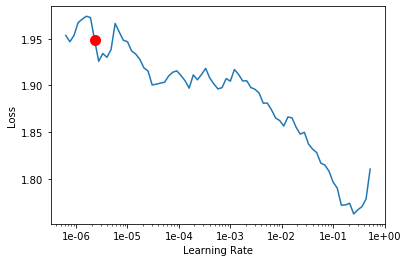

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion=True)

epoch,train_loss,valid_loss,time
0,0.930402,0.947941,00:40
1,0.855292,0.882385,00:40
2,0.757961,0.838024,00:40
3,0.648891,0.810898,00:40
4,0.556383,0.809414,00:41


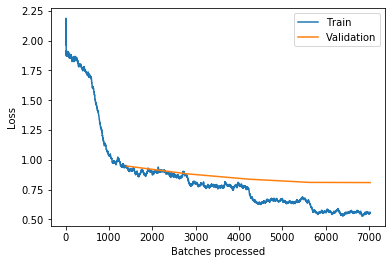

In [32]:
learn.fit_one_cycle(5, 5e-3)
learn.recorder.plot_losses()

In [33]:
learn.save('dotprod')

## Interpretation

In [34]:
learn.load('dotprod')

learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [39]:
g = rating_movie.groupby(title)['rating'].count()

top_movies = g.sort_values(ascending=False).index.values[:1000]
pd.Series(top_movies[:10])

0                 Star Wars (1977)
1                   Contact (1997)
2                     Fargo (1996)
3        Return of the Jedi (1983)
4                 Liar Liar (1997)
5      English Patient, The (1996)
6                    Scream (1996)
7                 Toy Story (1995)
8             Air Force One (1997)
9    Independence Day (ID4) (1996)
dtype: object

### Movie bias

In [40]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [45]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

item0 = lambda o:o[0]

sorted(movie_ratings, key=item0)[:10]

[(tensor(-0.3944),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2946),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2765), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2718), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2691), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2676), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2599), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2375), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2325), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2222), "McHale's Navy (1997)", 2.1884057971014492)]

In [46]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:10]

[(tensor(0.6375), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6105), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5601), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5464), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5394), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5318), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5287), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4980), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4976), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4950), 'As Good As It Gets (1997)', 4.196428571428571)]

### Movie weights

In [47]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [48]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [49]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1112), 'Wrong Trousers, The (1993)'),
 (tensor(1.0588), 'Lawrence of Arabia (1962)'),
 (tensor(1.0531), 'Chinatown (1974)'),
 (tensor(1.0363), 'Third Man, The (1949)'),
 (tensor(1.0285), 'Close Shave, A (1995)'),
 (tensor(1.0207), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(1.0204), 'Casablanca (1942)'),
 (tensor(0.9773), 'Godfather, The (1972)'),
 (tensor(0.9725), 'Citizen Kane (1941)'),
 (tensor(0.9682), 'Secrets & Lies (1996)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2074), 'Jungle2Jungle (1997)'),
 (tensor(-1.2051), "McHale's Navy (1997)"),
 (tensor(-1.1906), 'Home Alone 3 (1997)'),
 (tensor(-1.1573), 'Congo (1995)'),
 (tensor(-1.1252), 'Bio-Dome (1996)'),
 (tensor(-1.1174), 'Leave It to Beaver (1997)'),
 (tensor(-1.1004), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0963), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0890), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0352), 'Batman & Robin (1997)')]

In [52]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8465), 'Trainspotting (1996)'),
 (tensor(0.8373), 'Clockwork Orange, A (1971)'),
 (tensor(0.8275), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7859), 'Crumb (1994)'),
 (tensor(0.7855), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7567), 'Stupids, The (1996)'),
 (tensor(0.7477), 'Dead Man (1995)'),
 (tensor(0.7447), 'Cable Guy, The (1996)'),
 (tensor(0.7323), 'Jude (1996)'),
 (tensor(0.7289), 'Event Horizon (1997)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1340), 'Braveheart (1995)'),
 (tensor(-1.0442), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9629), 'Titanic (1997)'),
 (tensor(-0.9330), 'American President, The (1995)'),
 (tensor(-0.9249), 'Pretty Woman (1990)'),
 (tensor(-0.8981), "It's a Wonderful Life (1946)"),
 (tensor(-0.8657), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8580), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8453), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8255), 'Lion King, The (1994)')]

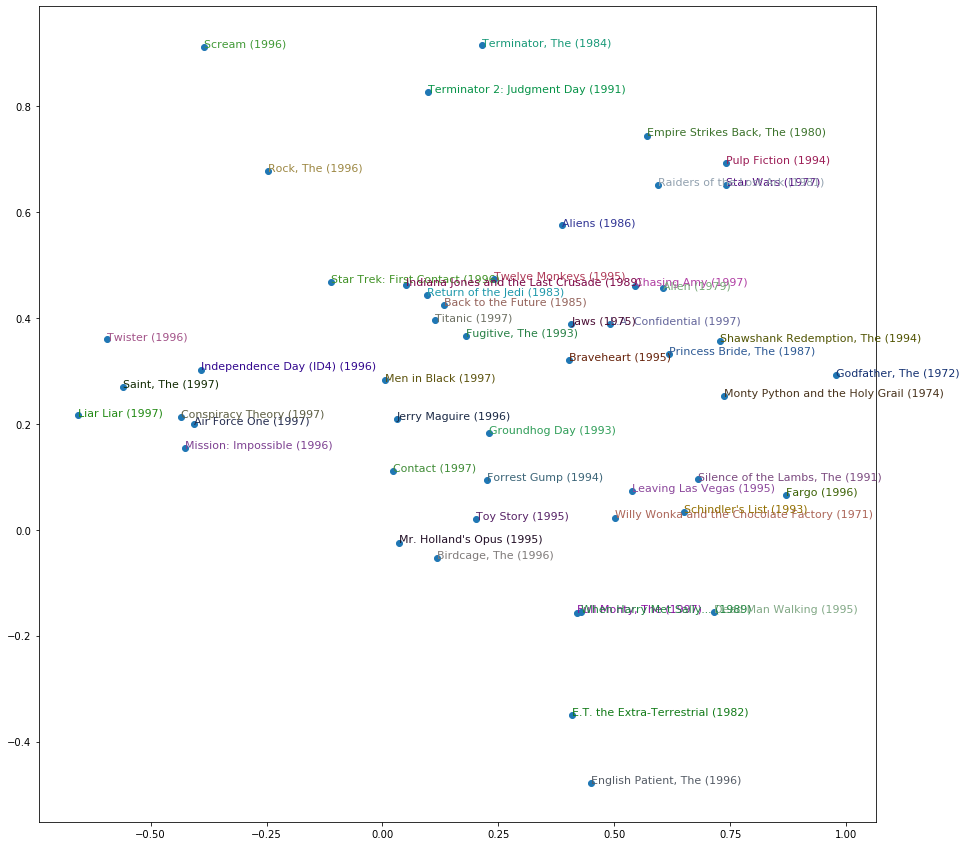

In [56]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()